# Gaps on structure functions: demo of pipeline

- Inspired by existing code
- Test on one PSP to start, then two PSP and one Wind for training and testing
- Check against target dataframes as you go

### 0. Import dependencies

In [1]:
import pickle
import pandas as pd
import numpy as np
import ts_dashboard_utils as ts
import src.utils as utils  # copied directly from Reynolds project, normalize() added
import src.params as params
import src.sf_funcs as sf
import sys
import src.data_import_funcs as dif
import json
import glob
import importlib
import matplotlib.pyplot as plt
#plt.rcParams.update({"font.size": 16})
import matplotlib.dates as mdates

In [2]:
# For current Wind importing

sys_arg_dict = {
    # arg1
    "mag_path": params.mag_path,
    "proton_path": params.proton_path,
    "electron_path": params.electron_path,
    # arg2
    "mag_vars": [params.timestamp, params.Bwind, params.Bwind_vec],
    "proton_vars": [params.timestamp, params.np, params.Tp],
    "electron_vars": [params.timestamp, params.ne, params.Te],
    # arg3
    "mag_thresh": params.mag_thresh,
    "proton_thresh": params.proton_thresh,
    "electron_thresh": params.electron_thresh,
    # arg4
    "dt_hr": params.dt_hr,
    "int_size": params.int_size,
    # arg5
    "dt_lr": params.dt_lr,
}

### 1. Download files

Run in terminal

In [3]:
# For selecting a range of dates

# wget --no-clobber --directory-prefix=data/raw/psp  https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn/2018/psp_fld_l2_mag_rtn_20181102{00..12}_v02.cdf
# wget --no-clobber --directory-prefix=data/raw/wind/ https://spdf.gsfc.nasa.gov/pub/data/wind/mfi/mfi_h2/2016/wi_h2_mfi_201601{01..07}_v05.cdf

# For entire folders

# wget --no-clobber --directory-prefix=data/raw/psp --recursive -np -nv -nH --cut-dirs=7 --accept cdf  https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn/2018/
# wget --no-clobber --directory-prefix=data/raw/wind --recursive -np -nv -nH --cut-dirs=2 --accept cdf  https://spdf.gsfc.nasa.gov/pub/data/wind/mfi/mfi_h2/

### 2. Read in data and split into standardised intervals

#### PSP data

In [4]:
raw_file_list = sorted(glob.iglob("data/raw/psp/" + "/*.cdf"))
print(raw_file_list)

['data/raw/psp\\psp_fld_l2_mag_rtn_2018110200_v02.cdf', 'data/raw/psp\\psp_fld_l2_mag_rtn_2018110206_v02.cdf', 'data/raw/psp\\psp_fld_l2_mag_rtn_2018110212_v02.cdf']


In [5]:
psp_data = dif.read_cdfs(
    [raw_file_list[0]],  # LIMIT HERE!
    {"epoch_mag_RTN": (0), "psp_fld_l2_mag_RTN": (0, 3), "label_RTN": (0, 3)},
)
psp_data_ready = dif.extract_components(
    psp_data,
    var_name="psp_fld_l2_mag_RTN",
    label_name="label_RTN",
    time_var="epoch_mag_RTN",
    dim=3,
)
psp_df = pd.DataFrame(psp_data_ready)
psp_df["Time"] = pd.to_datetime("2000-01-01 12:00") + pd.to_timedelta(
    psp_df["epoch_mag_RTN"], unit="ns"
)
psp_df = psp_df.drop(columns="epoch_mag_RTN").set_index("Time")

df_raw = psp_df["B_R"]

print(df_raw.info())
print(df_raw.head())

reading file  data/raw/psp\psp_fld_l2_mag_rtn_2018110200_v02.cdf


Done reading data
<class 'pandas.core.series.Series'>
DatetimeIndex: 1582027 entries, 2018-11-02 00:01:09.195182976 to 2018-11-02 06:01:09.171900544
Series name: B_R
Non-Null Count    Dtype  
--------------    -----  
1582027 non-null  float64
dtypes: float64(1)
memory usage: 24.1 MB
None
Time
2018-11-02 00:01:09.195182976   -11.061315
2018-11-02 00:01:09.208836480   -10.854164
2018-11-02 00:01:09.222489856   -11.197883
2018-11-02 00:01:09.236143104   -11.008248
2018-11-02 00:01:09.249796352   -11.188342
Name: B_R, dtype: float64


#### Wind data
Takes a while due to large files

In [6]:
# raw_file_list = sorted(glob.iglob("data/raw/wind/" + "/*.cdf"))
# print(raw_file_list)

In [7]:
# df = utils.pipeline(
#     raw_file_list[0],
#     varlist=sys_arg_dict["mag_vars"],
#     thresholds=sys_arg_dict["mag_thresh"],
#     cadence=sys_arg_dict["dt_hr"],
# )

# print("Reading {0}: {1:.2f}% missing".format(raw_file_list[0], df.iloc[:,0].isna().sum()/len(df)*100))

# # Ensuring observations are in chronological order
# df_wind_hr = df.sort_index()

# # df_wind_hr = pd.read_pickle("data/processed/" + params.mag_path + params.dt_hr + ".pkl")
# df_wind_hr = df_wind_hr.rename(
#     columns={
#         params.Bwind: "Bwind",
#         params.Bx: "Bx",
#         params.By: "By",
#         params.Bz: "Bz",
#     }
# )

# missing = df_wind_hr.iloc[:, 0].isna().sum() / len(df_wind_hr)

# if missing > 0.4:
#     # Replacing values in lists with na
#     print("Large missing %")
# else:
#     int_wind_hr = df_wind_hr.interpolate().ffill().bfill()

# df_raw = int_wind_hr["Bx"]

# print(df_raw.info())
# print(df_raw.head())

In [8]:
### 0PTIONAL CODE ###

if df_raw.isnull().sum() == 0:
    print("No missing data")
else:
    print(f"{df_raw.isnull().sum()} missing points")
print("Length of interval: " + str(df_raw.notnull().sum()))
print("Duration of interval: " + str(df_raw.index[-1] - df_raw.index[0]))
x = df_raw.values

# Frequency of measurements
print("Duration between some adjacent data points:")
print(df_raw.index[2] - df_raw.index[1])
print(df_raw.index[3] - df_raw.index[2])
print(df_raw.index[4] - df_raw.index[3])

a = df_raw.index[2] - df_raw.index[1]
x_freq = 1 / (a.microseconds / 1e6)
print("\nFrequency is {0:.2f} Hz (2dp)".format(x_freq))

print("Mean = {}".format(np.mean(x)))
print("Standard deviation = {}\n".format(np.std(x)))

### 0PTIONAL CODE END ###

No missing data
Length of interval: 1582027
Duration of interval: 0 days 05:59:59.976717568
Duration between some adjacent data points:
0 days 00:00:00.013653376
0 days 00:00:00.013653248
0 days 00:00:00.013653248

Frequency is 73.24 Hz (2dp)
Mean = -28.383399058746512
Standard deviation = 18.777635215345533



In [9]:
times_to_gap = 2

In [10]:
tc_approx = 500  # s: 500 for PSP, 2000 for Wind
cadence_approx = 0.1  # s: 0.1 for PSP, 1 for Wind

tc_n = 10  # Number of actual (computed) correlation times we want in our standardised interval...
interval_length = 10000  # ...across this many points

df = df_raw.resample(str(cadence_approx) + "S").mean()

ints = []
tc_list = []
cadence_list = []

time_lags_lr, r_vec_lr = utils.compute_nd_acf(
    [df],
    nlags=10000,
    plot=False,
)

tc = utils.compute_outer_scale_exp_trick(time_lags_lr, r_vec_lr, plot=False)

if tc == -1:
    tc = tc_approx
    new_cadence = tc_n * tc / interval_length
    print(
        f"tc not found for this interval, setting to 500s (default) -> cadence = {new_cadence}s"
    )

else:
    new_cadence = tc_n * tc / interval_length
    print(
        f"tc calculated to be {np.round(tc,2)}s -> cadence = {np.round(new_cadence,2)}s (for {tc_n}tc across {interval_length} points)"
    )

tc_list.append(tc)
cadence_list.append(new_cadence)

try:
    interval_approx_resampled = df.resample(
        str(np.round(new_cadence, 3)) + "S"
    ).mean()  # Resample to higher frequency

    for i in range(
        0, len(interval_approx_resampled) - interval_length + 1, interval_length
    ):
        interval = interval_approx_resampled.iloc[i : i + interval_length]
        # Check if interval is complete
        if interval.isnull().sum() > 0:
            print("interval contains missing data even after down-sampling; skipping")
            # Note: due to merging cannot identify specific file with missing data here
            # only file list as here:
            # print("corresponding input file list: ", file_list_split[core])
        else:
            # print("Interval successfully processed")
            int_norm = utils.normalize(interval)
            ints.append(int_norm)

except Exception as e:
    print(f"An error occurred: {e}")

if len(ints) == 0:
    print("No good inputs found (ints is empty). Exiting.")
    exit(1)

# Logarithmically-spaced lags?
# vals = np.logspace(0, 3, 0.25 * len(ints[0]))
# lags = np.unique(vals.astype(int))
lags = np.arange(1, 0.25 * len(ints[0]))
powers = [0.5, 2]

print(
    "\nNumber of standardised intervals: ",
    len(ints),
    "about to be gapped",
    times_to_gap,
    "times",
)

tc calculated to be 736.2s -> cadence = 0.74s (for 10tc across 10000 points)

Number of standardised intervals:  2 about to be gapped 2 times


Text(0, 0.5, '$B_R$ (nT)')

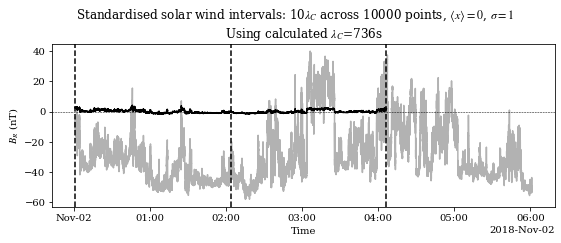

In [11]:
fig, ax = plt.subplots(figsize=(9, 3))
plt.plot(df, alpha=0.3, c="black")
plt.axvline(df.index[0], c="black", linestyle="dashed")
[
    plt.axvline(interval.index[-1], c="black", linestyle="dashed")
    for interval in ints
]
[plt.plot(interval, c="black") for interval in ints]
plt.axhline(0, c="black", linewidth=0.5, linestyle="--")
plt.suptitle(
    f"Standardised solar wind intervals: {tc_n}$\lambda_C$ across {interval_length} points, $\langle x \\rangle=0$, $\sigma=1$", y= 1.05
)
# # Add subtitle
plt.title(f"Using calculated $\lambda_C$={int(tc)}s")

# ax.set_xlim(interval_list_approx[0].index[0], interval_list_approx[2].index[-1])
ax.set_xlabel("Time")
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_ylabel("$B_R$ (nT)")
# Tidy the timestamp x-axis
# plt.xticks(rotation=20)

# plt.savefig("plots/int_standardised_demo.png")

In [12]:
raw_interval_metadata = pd.DataFrame({
    "raw_int_start": df.index[0],
    "raw_int_end": df.index[-1],
    "tc": tc_list,
    "cadence": cadence_list,
})
raw_interval_metadata

,raw_int_start,raw_int_end,tc,cadence
0,2018-11-02 00:01:09.100,2018-11-02 06:01:09.100,736.199,0.736199


In [41]:
ints_meta = pd.DataFrame({
    "int_start": [interval.index[0] for interval in ints],
    "int_end": [interval.index[-1] for interval in ints],
})
ints_meta.reset_index(inplace=True)
ints_meta.rename(columns={"index": "int_index"}, inplace=True)
ints_meta

,int_index,int_start,int_end
0,0,2018-11-02 00:01:08.448,2018-11-02 02:03:47.712
1,1,2018-11-02 02:03:48.448,2018-11-02 04:06:27.712


### 3. Calculate the true SF and slope for each interval

In [14]:
lags = np.arange(1, 0.1 * len(ints[0]))
powers = [0.5, 2]

In [42]:
sfs = pd.DataFrame()

for i, input in enumerate(ints):
    # print(f"\nCore {core} processing standardised interval {i}")
    good_output, slope = sf.compute_sf(pd.DataFrame(input), lags, powers, False, False, [10,100])
    
    good_output.insert(0, "int_index", i)
    sfs = pd.concat([sfs, good_output])
    ints_meta.loc[ints_meta["int_index"]==i, "slope"] = slope

sfs.head()

,int_index,lag,n,missing_percent,sf_0.5,sf_0.5_se,sf_2,sf_2_se
1.0,0,1.0,9999,0.0,0.239586,0.001398,0.015702,0.000594
2.0,0,2.0,9998,0.0,0.285889,0.001679,0.032877,0.001324
3.0,0,3.0,9997,0.0,0.311522,0.001843,0.047024,0.001895
4.0,0,4.0,9996,0.0,0.330458,0.001971,0.059901,0.002304
5.0,0,5.0,9995,0.0,0.344736,0.002068,0.071729,0.002690


[]

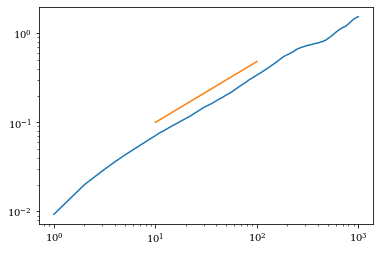

In [16]:
from src.data_import_funcs import pltpwrl
plt.plot(sfs.loc[sfs["int_index"]==1, "lag"], sfs.loc[sfs["int_index"]==1, "sf_2"])
pltpwrl(10,0.1, 10, 100, ints_meta.loc[ints_meta["int_index"]==1, "slope"].values)
plt.semilogx()
plt.semilogy()

Briefly limiting to processing single interval

### 4. Duplicate, gap and interpolate intervals, and calculate SFs and slopes

In [17]:
minimum_missing_chunks = 0.7

In [18]:
index_list = []
version_list = []
handling_list = []
missing_list = []
slopes_list = []

sfs_copies = pd.DataFrame()
ints_copies = pd.DataFrame()

for index in range(len(ints)):
    input = ints[index]

    for j in range(times_to_gap):
        total_removal = np.random.uniform(0, 0.95)
        ratio_removal = np.random.uniform(minimum_missing_chunks, 1)
        # print("Nominal total removal: {0:.1f}%".format(total_removal * 100))
        # print("Nominal ratio: {0:.1f}%".format(ratio_removal * 100))
        prop_remove_chunks = total_removal * ratio_removal
        prop_remove_unif = total_removal * (1 - ratio_removal)
        bad_input_temp, bad_input_ind, prop_removed = ts.remove_data(
            input, prop_remove_chunks, chunks=np.random.randint(1, 10)
        )
        bad_input, bad_input_ind, prop_removed = ts.remove_data(
            bad_input_temp, prop_remove_unif
        )
        if prop_removed >= 0.95 or prop_removed == 0:
            # print(">95% or 0% data removed, skipping")
            continue

        bad_output, slope = sf.compute_sf(pd.DataFrame(bad_input), lags, powers, False, False, [10,100])
        bad_output["int_index"] = index
        bad_output["version"] = j
        bad_output["handling"] = "none"
        sfs_copies = pd.concat([sfs_copies, bad_output])

        for handling in ["none", "lint"]:
            index_list.append(index)
            version_list.append(j)
            missing_list.append(prop_removed*100)
            handling_list.append(handling)

            if handling == "none":
                slopes_list.append(slope)
                bad_input_df = pd.DataFrame(bad_input)
                bad_input_df["handling"] = handling
                    # Once we are done with computing the SF, add some metadata to the interval
                bad_input_df["int_index"] = index
                bad_input_df["version"] = j
                sfs_copies = pd.concat([ints_copies, bad_input_df])

            elif handling == "lint":
                interp_input = bad_input.interpolate(method="linear")
                interp_output, slope = sf.compute_sf(pd.DataFrame(interp_input), lags, powers, False, False, [10,100])
                slopes_list.append(slope)
                
                # # Once we are done with computing the SF, add some metadata to the interval
                interp_input_df = pd.DataFrame(interp_input)
                interp_input_df["int_index"] = index
                interp_input_df["version"] = j
                interp_input_df["handling"] = handling
                ints_copies = pd.concat([ints_copies, interp_input_df])

                interp_output["int_index"] = index
                interp_output["version"] = j
                interp_output["handling"] = handling
                
                # Correcting sample size and uncertainty for linear interpolation, same values as no handling
                interp_output["missing_percent"] = bad_output["missing_percent"]
                interp_output["sf_2_se"] = bad_output["sf_2_se"]

                sfs_copies = pd.concat([sfs_copies, interp_output])

In [39]:
ints_copies_meta = pd.DataFrame({"int_index": index_list, "version": version_list, "missing_percent_overall": missing_list, "gap_handling": handling_list, "slope": slopes_list})
ints_copies_meta

,int_index,version,missing_percent_overall,gap_handling,slope
0,0,0,31.26,none,0.654488
1,0,0,31.26,lint,0.666914
2,0,1,80.45,none,0.644263
3,0,1,80.45,lint,0.635240
4,1,0,25.59,none,0.607894
5,1,0,25.59,lint,0.602388
6,1,1,34.21,none,0.530965
7,1,1,34.21,lint,0.567990


Plot all bad and interpolated intervals, with true in background

In [22]:
index = 0
i = 0
ints[index].values

array([2.31647219, 2.33887956, 2.4126522 , ..., 0.25040398, 0.23969982,
       0.29300482])

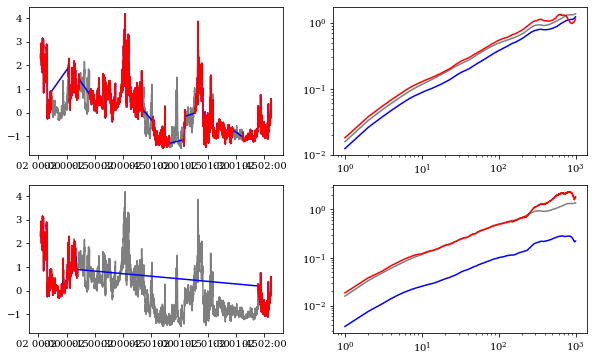

In [36]:
# # Quick check of results
index = 0
n_versions = 2

fig, ax = plt.subplots(n_versions, 2, figsize=(10, n_versions*3))
for i in range(n_versions):
    ax[i, 0].plot(ints[index], alpha=0.5, c="black")
    ax[i, 0].plot(ints_copies.loc[((ints_copies["int_index"]==index) & (ints_copies["handling"]=="lint") & (ints_copies["version"]==i)),"B_R"], c="blue")
    ax[i, 0].plot(ints_copies.loc[((ints_copies["int_index"]==index) & (ints_copies["handling"]=="none") & (ints_copies["version"]==i)),"B_R"], c="red")

    ax[i, 1].plot(sfs.loc[sfs["int_index"]==index,"sf_2"], alpha=0.5, c="black")
    ax[i, 1].plot(sfs_copies.loc[((sfs_copies["int_index"]==index) & (sfs_copies["handling"]=="lint") & (sfs_copies["version"]==i)),"sf_2"], c="blue")
    ax[i, 1].plot(sfs_copies.loc[((sfs_copies["int_index"]==index) & (sfs_copies["handling"]=="none") & (sfs_copies["version"]==i)),"sf_2"], c="red")
    ax[i, 1].semilogx()
    ax[i, 1].semilogy()
#plt.savefig("data/processed/validation_plot.png")
#print("Validation plot saved")


### 5. Calculate errors relative to true values

Join original and copies dataframes and do column operation

In [45]:
ints_meta_full = pd.merge(ints_meta, ints_copies_meta, how="inner", on="int_index", suffixes=("_orig", "_copy"))
ints_meta_full["slope_pe"] = (ints_meta_full["slope_copy"] - ints_meta_full["slope_orig"]) / ints_meta_full["slope_orig"] * 100
ints_meta_full

,int_index,int_start,int_end,slope_orig,version,missing_percent_overall,gap_handling,slope_copy,slope_pe
0,0,2018-11-02 00:01:08.448,2018-11-02 02:03:47.712,0.646207,0,31.26,none,0.654488,1.281558
1,0,2018-11-02 00:01:08.448,2018-11-02 02:03:47.712,0.646207,0,31.26,lint,0.666914,3.204459
2,0,2018-11-02 00:01:08.448,2018-11-02 02:03:47.712,0.646207,1,80.45,none,0.644263,-0.300747
3,0,2018-11-02 00:01:08.448,2018-11-02 02:03:47.712,0.646207,1,80.45,lint,0.635240,-1.697035
4,1,2018-11-02 02:03:48.448,2018-11-02 04:06:27.712,0.682743,0,25.59,none,0.607894,-10.963056
5,1,2018-11-02 02:03:48.448,2018-11-02 04:06:27.712,0.682743,0,25.59,lint,0.602388,-11.769534
6,1,2018-11-02 02:03:48.448,2018-11-02 04:06:27.712,0.682743,1,34.21,none,0.530965,-22.230717
7,1,2018-11-02 02:03:48.448,2018-11-02 04:06:27.712,0.682743,1,34.21,lint,0.567990,-16.807605


In [ ]:
sfs_copies_full = pd.merge(sfs, sfs_copies, how="inner", on=["int_index", "lag"], suffixes=("_orig", "_copy"))
sfs_copies_full["sf_2_pe"] = (sfs_copies_full["sf_2_copy"] - sfs_copies_full["sf_2_orig"]) / sfs_copies_full["sf_2_orig"] * 100
sfs_copies_full.head()

,int_index,lag,n_orig,missing_percent_orig,sf_0.5_orig,sf_0.5_se_orig,sf_2_orig,sf_2_se_orig,n_copy,missing_percent_copy,sf_0.5_copy,sf_0.5_se_copy,sf_2_copy,sf_2_se_copy,version,handling,sf_2_pe
0,0,1.0,9999,0.0,0.239586,0.001398,0.015702,0.000594,4137,58.625863,0.243112,0.002227,0.016815,0.000974,0,none,7.087634
1,0,1.0,9999,0.0,0.239586,0.001398,0.015702,0.000594,9998,58.625863,0.120824,0.001492,0.007565,0.000974,0,lint,-51.823195
2,0,1.0,9999,0.0,0.239586,0.001398,0.015702,0.000594,1769,82.308231,0.256847,0.003472,0.018328,0.001281,1,none,16.726663
3,0,1.0,9999,0.0,0.239586,0.001398,0.015702,0.000594,9999,82.308231,0.060840,0.001191,0.003666,0.001281,1,lint,-76.654977
4,0,2.0,9998,0.0,0.285889,0.001679,0.032877,0.001324,4130,58.691738,0.285035,0.002624,0.033001,0.001994,0,none,0.377413


Calculate MAPE for each interval copy

In [43]:
subset = df[list(combination)]
mean_values = subset.mean()
means_list.append(mean_values)

,int_index,version,missing_percent_overall,gap_handling,slope
0,0,0,31.26,none,0.654488
1,0,0,31.26,lint,0.666914
2,0,1,80.45,none,0.644263
3,0,1,80.45,lint,0.635240
4,1,0,25.59,none,0.607894
5,1,0,25.59,lint,0.602388
6,1,1,34.21,none,0.530965
7,1,1,34.21,lint,0.567990


<Axes: >

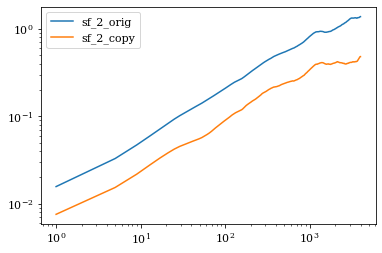

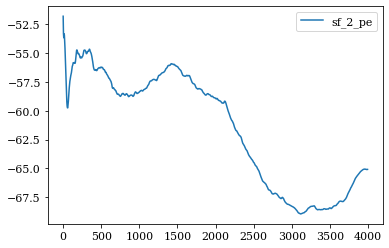

In [ ]:
check = sfs_copies_full[(sfs_copies_full["int_index"]==0) & (sfs_copies_full["version"]==0) & (sfs_copies_full["handling"]=="lint")]
check[["sf_2_orig", "sf_2_copy"]].plot()
plt.semilogx()
plt.semilogy()
check[[ "sf_2_pe"]].plot()

### 6. For PSP training set, create 2D and 3D heatmaps and export

### 7. For PSP and Wind test sets, apply the correction factor and calculate slopes

### 8. Again calculate errors relative to true values